In [3]:
import sys
import os
import jax
import jax.numpy as jnp
from jax import vmap, pmap, jit, grad
import numpy as onp
from astropy.io import fits
from astropy import units as u
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import pysynphot as S
import time
from tqdm.notebook import tqdm
import morphine
import morphine_model
import scipy
from jax.config import config
config.update("jax_enable_x64", True)

from time import time as clock
from IPython.display import clear_output

133216.36890302628
1490


/suphys/cdea7424/.conda/envs/main/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


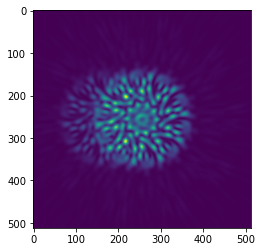

In [4]:
data = fits.open('20wavsPSFs/Zernikes/RMS_norm/correct_Epoch100.fits')
#print(data[0].header)
image = data[1].data
flux = 1.8e9 / 1
image = image*flux
plt.imshow(image)
print(jnp.max(image))

saturated_pix = image[image >= 80000]
print(len(saturated_pix))

In [3]:
# for i in range(20):
#     zern = morphine.zernike.zern_name(i+1)
#     path = '20wavsPSFs/Zernikes/{}/1nm_norm'.format(zern)
#     os.makedirs(path)

In [4]:
###################
# Star Parameters #
###################

n_wavs = 20
central_wav = 550e-9 # m
width = 115e-9 # m
wavs = jnp.linspace(central_wav-width/1.6,central_wav+width/1.6,num=n_wavs) # Go a bit past the edges

filter_n,filter_sigma = 8,105e-9 
central_wav = onp.random.normal(scale=0e-11,loc=550e-9)
bandpass = morphine_model.supergaussian(wavs,central_wav,sigma=filter_sigma,n=filter_n)

primary_teff_A = 5790   #temp
primary_z_A = 0.2       #metallicity    - numbers from wikipedia
primary_logg_A = 4.3    #gravity
acenA = S.Icat('phoenix',primary_teff_A,primary_z_A,primary_logg_A)
specA = acenA.sample(wavs*1e10)
specA /= jnp.max(specA*bandpass)
weights_A = specA*bandpass

primary_teff_B = 5260   #temp
primary_z_B = 0.23      #metallicty
primary_logg_B = 4.37   #gravity
acenB = S.Icat('phoenix',primary_teff_B,primary_z_B,primary_logg_B)
specB = acenB.sample(wavs*1e10)
specB /= jnp.max(specB*bandpass)
weights_B = specB*bandpass

/suphys/cdea7424/.conda/envs/main/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
#############################
# Simulated Detector Params #
#############################
pscale = 0.156
num_pix = 512
pdiam2 = 0.13
osamp = 2

NZ = 20
zernikes = morphine.zernike.zernike_basis(NZ,npix=num_pix,outside=0.0) 

In [6]:
#####################
### Pupil Loading ###
#####################

def get_aperture(size, radius=None):
    """
    Produces an array to be used to represent the magnitude of light at the aperture of a telescope.
    Ie an array of zeros with a circle of ones at the centre
    Parameters:
        size: The size of the array to return
        radius (optional): The radius which defines the boundary of the aperture, if left as None it
        will extend the aperture to the edged of the array (ie radius = size/2)
    Returns:
        aperture: An array of zeros with a circular section in the middle of ones
    """
    c = size/2
    xs = jnp.linspace(-c, c, size, endpoint=False)
    Xs, Ys = jnp.meshgrid(xs, xs)
    Rs = jnp.hypot(Xs, Ys)
    
    if radius is None:
        aperture = jnp.where(Rs > c, 0, jnp.ones([size, size]))
    else:
        aperture = jnp.where(Rs > radius, 0, jnp.ones([size, size]))
    return aperture

from scipy.ndimage import zoom
def get_toliman_pupil(size, path=None):
    """
    Loads in the Toliman pupil file and returns a scaled version of dimension 'size'. 
    The pupil is returned as a complex array.
    Parameters:
        size: The size of the final output array
        path (optional): The path to the "Toliman_pupil.npy" file. If left as None it will
        look for the file in the current working directory
    Returns:
        toliman_pupil_scaled: A scaled version of the Toliman pupil returned as a complex array
    """
    if path is None:
        toliman_pupil = jnp.load("Toliman_pupil.npy")
    else:
        toliman_pupil = jnp.load("{}/Toliman_pupil.npy".format(path))
        
    phase = jnp.angle(toliman_pupil)
    size_in = phase.shape[0]
    ratio = float(size/size_in)
    phase_scaled = zoom(phase, ratio, order=0)
    toliman_pupil_out = get_aperture(size) * jnp.exp(1j * phase_scaled)
    return toliman_pupil_out

In [7]:
pupil = get_toliman_pupil(osamp*num_pix)
aperture_array = jnp.abs(pupil)
opd = central_wav*jnp.angle(pupil)/(2*jnp.pi)

In [8]:
toliman_Sidelobes = morphine_model.TolimanAperture(add_grating=True,grating_fact=0.0003,telescope_diam=0.13,
                                    central_wav=central_wav,achromatic_pupil = True,grating_amp=jnp.sqrt(0.1), pupil_file = 'Toliman_pupil.npy')


In [9]:
############################
# Image creating functions #
############################

def generate_opsys(zern_coeffs = jnp.zeros(20)):
    zernikes = morphine.zernike.zernike_basis(NZ,npix=num_pix,outside=0.0) 
    # fix this
    opsys = morphine.OpticalSystem(npix = num_pix)
    opsys.add_pupil(toliman_Sidelobes)
    opsys.pupil_diameter = pdiam2 
    wf = opsys.input_wavefront()
    thinlens = morphine.ZernikeWFE(radius=pdiam2/2, coefficients=zern_coeffs, cached_zernikes=zernikes)
    opsys.add_pupil(thinlens)

    opsys.add_detector(pixelscale=pscale, fov_arcsec=pscale*num_pix/2) 
    return opsys

def get_psf(r, theta, osys, wl):
    osys.source_offset_r = r # arcseconds
    osys.source_offset_theta = theta # degrees
    psf = osys.propagate_mono(wl)[0].intensity
    return psf/onp.sum(psf)
get_psf_vmap = vmap(get_psf, in_axes=(None, None, None, 0))

def get_bb_psf(r, theta, osys, wavels, weights, sigma=0):
    psf_stack = get_psf_vmap(r, theta, osys, wavels)
    psf_stack *= weights.reshape([len(weights), 1, 1])
    psf = jnp.sum(psf_stack, axis=0)
    return psf/jnp.sum(psf)


def get_double_bb_psf(r, theta, osys, wavels, weights1, weights2, sigma = 0):
    starA = get_bb_psf(0, 0, osys, wavels, weights1, sigma)
    #starA = np.array(star1)
    starB = get_bb_psf(r, theta, osys, wavels, weights2, sigma)
   # starB = onp.array(star2)
    return starB*0.25+starA*0.75 ##approximate luminosity contribution

In [14]:
def cramer_rao_bound(image):
    """ Calculate the Cramer-Rao bound on the accuracy of a position measurement for a single image.
    Returns the expected standard deviation of the position measurement in the x and y directions.
    """
    # calculate derivative at each pixel. Use symmetric two-point derivative
    dg_dx = (image[:,2:]-image[:,:-2])/2
    dg_dy = (image[2:]-image[:-2])/2

    var_x = 1/(jnp.sum(dg_dx**2 / image[:,1:-1]))
    var_y = 1/(jnp.sum(dg_dy**2 / image[1:-1]))

    std_x = jnp.sqrt(var_x)
    std_y = jnp.sqrt(var_y)
    
    return std_x,std_y

def get_cramer(image, flux):
    std_x, std_y = cramer_rao_bound(image*flux)
    std_sec_x = std_x*jnp.sqrt(3) # magic number is the binary contrast ratio
    std_sec_y = std_y*jnp.sqrt(3)

    std_sep_x = jnp.sqrt(std_x**2+std_sec_x**2)
    std_sep_y = jnp.sqrt(std_y**2+std_sec_y**2)
    std_sep = onp.mean([std_sep_x,std_sep_y])
    return std_sep

In [15]:
##########################
# Noise adding functions #
##########################

def apply_photon_noise(image, seed = None):
    if seed is not None:
        onp.seed(seed)
    image_noisy = onp.random.poisson(image)
    return image_noisy

def generate_detector_noise(npixels, nimages, standard_deviation, seed=None):
    if seed is not None:
        onp.seed(seed)
    thermal_noise = jnp.abs(onp.random.normal(0, standard_deviation, [nimages, npixels, npixels]))
    if nimages == 1:
        return thermal_noise[0]
    return thermal_noise

def pixel_faults(rate = 0.001, mean = 0.97, std = 0.01):
    '''
    Adds inhomogenities to pixels by making some less sensitive.
    rate: what % of pixels are faulty
    mean: faulty pixel sensitivity
    std: std of gaussian spread around mean
    
    NOTE: Only takes 512x512 images
    '''
    faulty_map = onp.random.rand(2000,2000)  # careful with this
    faulty_map[faulty_map > rate] = 0
    faulty_map[faulty_map > 0] = 1
    
    num_nonZero = len(faulty_map[faulty_map == 1])
    
    sensitivities = std*onp.random.randn(num_nonZero)+mean
    sensitivities[sensitivities > 1] = 1

    faulty_map[faulty_map > 0] = sensitivities
    faulty_map[faulty_map == 0] = 1
    return faulty_map

def make_noisy(image, flux):
    # photon and detector and pixel
    dark_current = 2 # electrons 2 
    PSF_photons = apply_photon_noise(flux * image)
    detector_noise = generate_detector_noise(num_pix, 1, dark_current)
    noisy_PSF = PSF_photons + detector_noise
    # new addition below
    noisy_PSF = noisy_PSF*pixel_faults()
    noisy_PSF = noisy_PSF/jnp.sum(noisy_PSF)
    return noisy_PSF

In [10]:
num_pix = 2000

In [11]:
normal_opsys = morphine.OpticalSystem()
normal_opsys.add_pupil(morphine.CircularAperture(radius = 0.13))
normal_opsys.add_detector(pixelscale=pscale, fov_arcsec=pscale*num_pix/2)

CPU times: user 5min 14s, sys: 9.6 s, total: 5min 23s
Wall time: 29.4 s


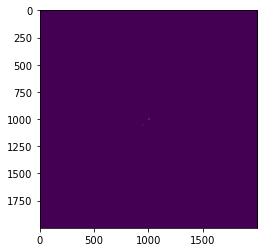

In [12]:
%%time
dot = get_bb_psf(0,0,normal_opsys, wavs, weights_A)
ddot = get_double_bb_psf(6,45, normal_opsys, wavs, weights_A, weights_B)
plt.imshow(ddot)

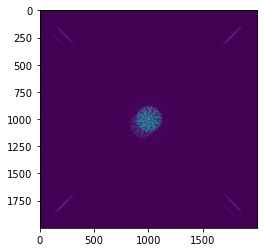

In [13]:
toliman_opsys = generate_opsys()
toliman_psf = get_double_bb_psf(6,45, toliman_opsys, wavs, weights_A, weights_B)
plt.imshow(toliman_psf)

In [21]:
flux = 1.8e9 *60*60
cramer = get_cramer(ddot, flux)
rao = get_cramer(toliman_psf, flux)

print(cramer)
print(rao)
print(rao/cramer)

1.6842534805473833e-06
5.978045160372713e-06
3.5493737904759115


Text(0.5, 1.0, 'Alpha Cen AB through TOLIMAN')

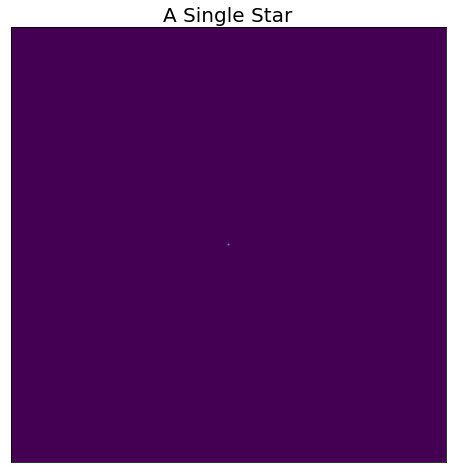

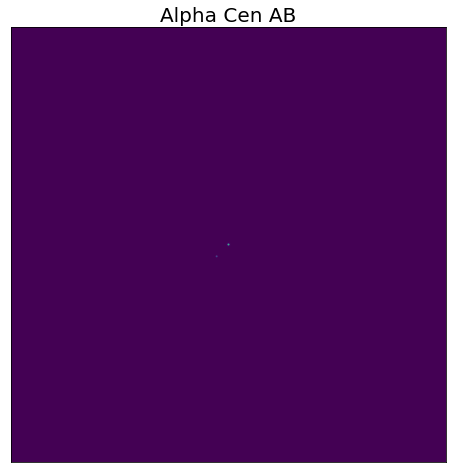

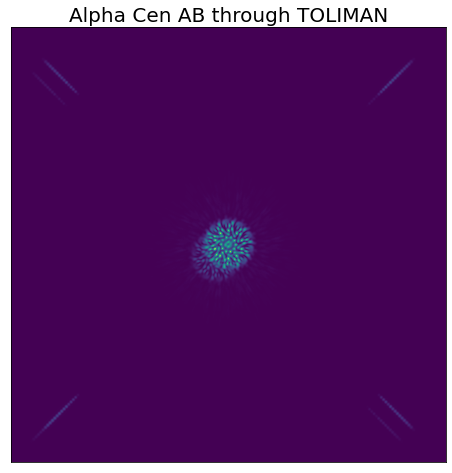

In [12]:
plt.figure(figsize= (8,8))
plt.imshow(dot)
plt.xticks([])
plt.yticks([])
plt.title('A Single Star', fontsize = 20)

plt.figure(figsize= (8,8))
plt.imshow(ddot)
plt.xticks([])
plt.yticks([])
plt.title('Alpha Cen AB', fontsize = 20)

plt.figure(figsize= (8,8))
plt.imshow(toliman_psf)
plt.xticks([])
plt.yticks([])
plt.title('Alpha Cen AB through TOLIMAN', fontsize = 20)

In [13]:
coefficients = onp.ones(20)*2e-8
aberrated_toliman_opsys = generate_opsys(coefficients)
aberrated_toliman_psf = get_bb_psf(0,0, aberrated_toliman_opsys, wavs, weights_A)
single_toliman_psf = get_bb_psf(0,0, toliman_opsys, wavs, weights_A)

Text(0.5, 1.0, 'Aberrated TOLIMAN PSF')

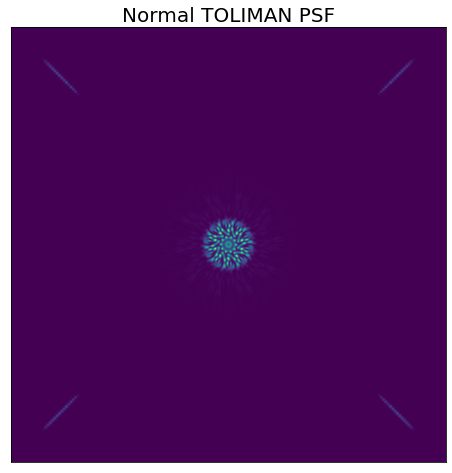

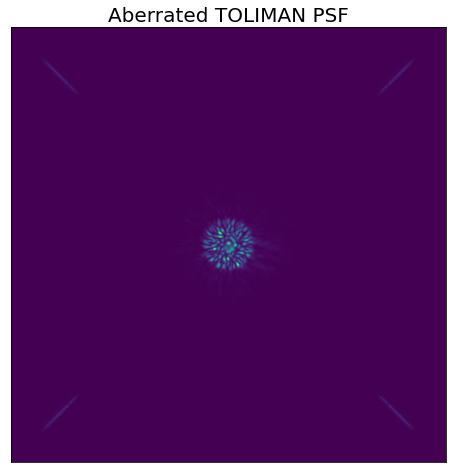

In [14]:
plt.figure(figsize = (8,8))
plt.imshow(single_toliman_psf)
plt.xticks([])
plt.yticks([])
plt.title('Normal TOLIMAN PSF', fontsize = 20)

plt.figure(figsize = (8,8))
plt.imshow(aberrated_toliman_psf)
plt.xticks([])
plt.yticks([])
plt.title('Aberrated TOLIMAN PSF', fontsize = 20)

In [15]:
%%time
pscale = 0.156
toliman_opsys = generate_opsys()
image_1 = get_bb_psf(0,0, toliman_opsys, wavs, weights_A)

pscale = 0.156*1.25
toliman_opsys = generate_opsys()
image_2 = get_bb_psf(0,0, toliman_opsys, wavs, weights_A)

pscale = 0.156*0.75
toliman_opsys = generate_opsys()
image_3 = get_bb_psf(0,0, toliman_opsys, wavs, weights_A)


CPU times: user 9min 35s, sys: 33.6 s, total: 10min 8s
Wall time: 1min 18s


Text(0.5, 1.0, 'Plate scale = 0.117 (25% lower)')

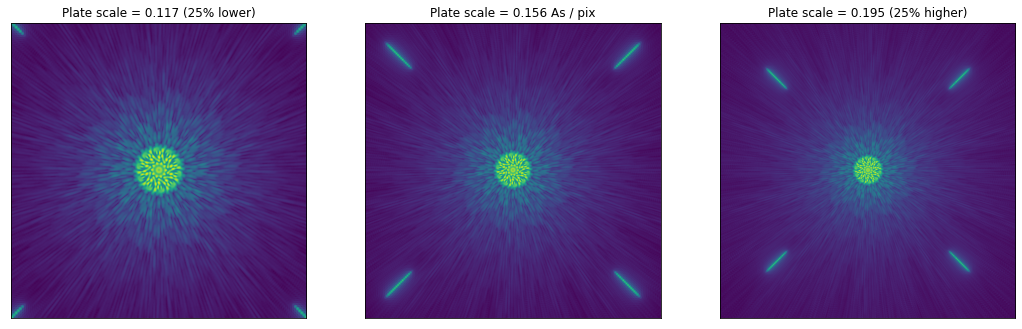

In [16]:
plt.figure(figsize = (18,6))

plt.subplot(1,3,2)
plt.imshow(image_1**0.2)
plt.xticks([])
plt.yticks([])
plt.title('Plate scale = 0.156 As / pix')

plt.subplot(1,3,3)
plt.imshow(image_2**0.2)
plt.xticks([])
plt.yticks([])
plt.title('Plate scale = 0.195 (25% higher)')

plt.subplot(1,3,1)
plt.imshow(image_3**0.2)
plt.xticks([])
plt.yticks([])
plt.title('Plate scale = 0.117 (25% lower)')


In [ ]:
def recover_signal(std, signal_strength = )

In [17]:
t = onp.linspace(0,26280,26281)
planet_signal = 0.25e-5*onp.sin(2*jnp.pi*(1/8760)*t)
std = (5.88e-6)*8 # pix  1 hr
#std = (4.56e-5)*1.25 # 1 min
#std = (3.5e-4)*1.25 # 1 sec
pscale = 0.156

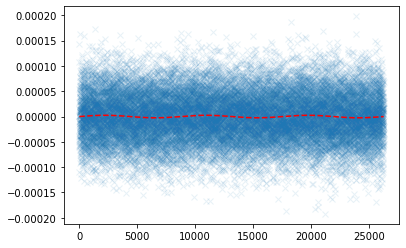

In [18]:
noise = onp.random.normal(loc = 0, scale = std, size = 26281)
noisy_signal = planet_signal+noise
plt.plot(noisy_signal, 'x', alpha = 0.1)
plt.plot(planet_signal, '--r')


In [19]:
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

2.0577952764857186e-06


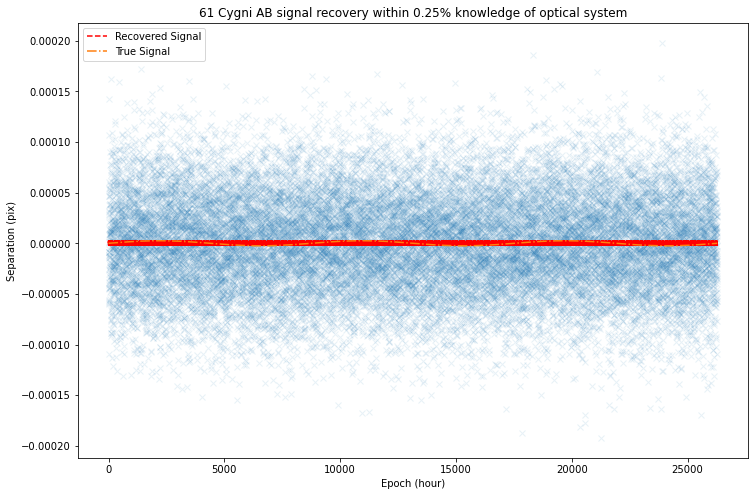

In [20]:
fits = fit_sin(t, noisy_signal)
print(fits['amp'])
fitted_planet_signal = fits['amp']*onp.sin(fits["omega"]*t)

plt.figure(figsize = (12,8))
plt.plot(noisy_signal, 'x', alpha = 0.1)
plt.plot(fitted_planet_signal, '--r', label = 'Recovered Signal')
plt.plot(planet_signal, '-.', label = 'True Signal')
plt.xlabel('Epoch (hour)')
plt.ylabel('Separation (pix)')
plt.title('61 Cygni AB signal recovery within 0.25% knowledge of optical system')
plt.legend()
#plt.plot(planet_signal)

In [21]:
def recovered_signal_accuracy(true_signal, std, exposure_time = 3600):
    # exposure time in seconds
    # true signal is magnitude of astrometric deflection in pix
    t_len = int((3*365*24*60*60) / exposure_time)
    tt = onp.linspace(0,t_len, t_len+1)
    
    planet_signal = true_signal*onp.sin(2*onp.pi*(1/(t_len/3))*tt)
    noise = onp.random.normal(loc = 0, scale = std, size = t_len+1)
    noisy_signal = planet_signal+noise
    
    recovered_signal = fit_sin(tt, noisy_signal)
    amplitude = recovered_signal['amp']
    freq = recovered_signal['omega']
    
    amp_acc = amplitude/true_signal
    freq_acc = freq / (2*onp.pi*3/t_len)
    return onp.array([amp_acc, freq_acc])
    
    

[1.07380123 1.01899505]


  0%|          | 0/100 [00:00<?, ?it/s]

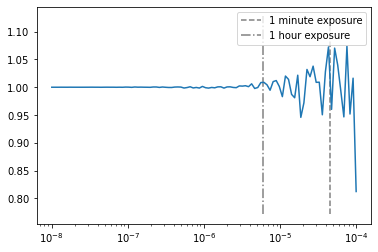

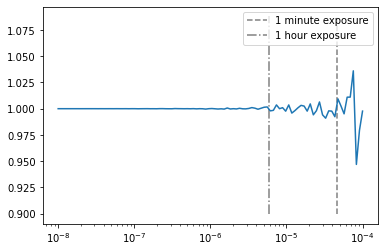

In [22]:
print(recovered_signal_accuracy(0.55e-5 , 3.88e-05))
acenAB_sig = 1.1e-6 / pscale
acenAB_amp = []
acenAB_freq = []

log_std_range = onp.linspace(4, 8, 100)
std_range = 10**(-log_std_range)

for i in tqdm(range(len(std_range))):
    acc = recovered_signal_accuracy(acenAB_sig, std_range[i])
    
    acenAB_amp = onp.append(acenAB_amp, acc[0])
    acenAB_freq = onp.append(acenAB_freq, acc[1])
    
plt.plot(std_range, acenAB_amp)
plt.vlines(10**(-4.34), onp.min(acenAB_amp)*0.95, onp.max(acenAB_amp)*1.05, ls = '--', color = 'grey', label = '1 minute exposure')
plt.vlines(10**(-5.23), onp.min(acenAB_amp)*0.95, onp.max(acenAB_amp)*1.05, ls = '-.', color = 'grey', label = '1 hour exposure')
plt.xscale('log')
plt.legend()

plt.figure()
plt.plot(std_range, acenAB_freq)
plt.vlines(10**(-4.34), onp.min(acenAB_freq)*0.95, onp.max(acenAB_freq)*1.05, ls = '--', color = 'grey', label = '1 minute exposure')
plt.vlines(10**(-5.23), onp.min(acenAB_freq)*0.95, onp.max(acenAB_freq)*1.05, ls = '-.', color = 'grey', label = '1 hour exposure')
plt.xscale('log')
plt.legend()

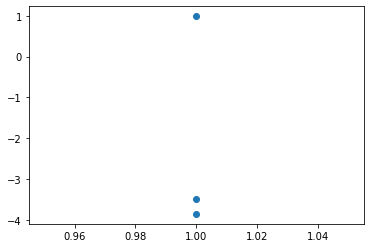

In [23]:
rao_1s = 3.53e-4
rao_1hr = 5.89e-6

rao_1hr_m2_5 = 84.5*rao_1hr
rao_1hr_p2_5 = 85*rao_1hr

rao_1s_m2_5 = 1.8*rao_1s
rao_1s_p2_5 = 1.95*rao_1s

x1s = [1,1,1]
x1hr = [3600,3600,3600]

secs = [rao_1s_m2_5, rao_1s, rao_1s_p2_5]
hours = [rao_1hr_m2_5, rao_1hr, rao_1hr_p2_5]

secs_amp_acc = []
secs_freq_acc = []

hours_amp_acc = []
hours_freq_acc = []

for i in range(3):
    acc_s = recovered_signal_accuracy(0.55e-5 , secs[i])
    secs_amp_acc = onp.append(secs_amp_acc, acc_s[0])
    secs_freq_acc = onp.append(secs_freq_acc, acc_s[0])
    
    acc_hr = recovered_signal_accuracy(0.55e-5 , hours[i])
    hours_amp_acc = onp.append(hours_amp_acc, acc_hr[0])
    hours_freq_acc = onp.append(hours_freq_acc, acc_hr[0])


plt.scatter(x1s, hours_freq_acc)



In [24]:
print(recovered_signal_accuracy(0.55e-5, 1.01204231e-04))

[0.85711201 0.96871765]


In [1]:
t = onp.linspace(0,26280,26281)
true_planet_signal = 0.55e-5*onp.sin(2*jnp.pi*(1/8760)*t)
planet_signal = 1.124*0.55e-5*onp.sin(2*jnp.pi*0.99*(1/8760)*t)
std = (5.88e-6)*1.25 # pix  1 hr


pscale = 0.156

NameError: name 'onp' is not defined

In [2]:
noise = onp.random.normal(loc = 0, scale = std, size = 26281)
noisy_signal = planet_signal+noise
plt.plot(noisy_signal, 'x', alpha = 0.1)
plt.plot(planet_signal, '--r')

NameError: name 'onp' is not defined

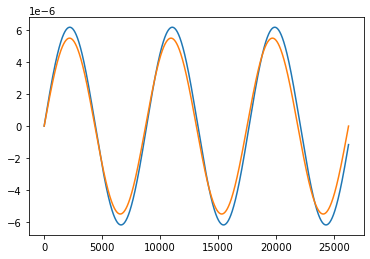

In [27]:
plt.plot(planet_signal)
plt.plot(true_planet_signal)
# this is for within 0.5 of zernikes

In [28]:
## to do:
## repeat this but for signal strength for other binaries and show how
## accurately we need to know zernikes to get a signal recovery.
## also make the slides and the speech

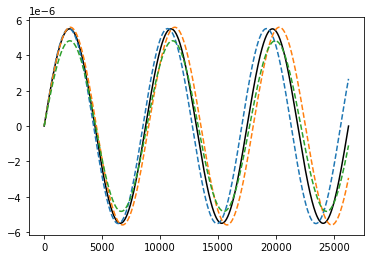

In [29]:
true_planet_signal = 0.55e-5*onp.sin(2*jnp.pi*(1/8760)*t)

test1 = recovered_signal_accuracy(0.55e-5, 1.01204231e-04)
test2 = recovered_signal_accuracy(0.55e-5, 1.01204231e-04)
test3 = recovered_signal_accuracy(0.55e-5, 1.01204231e-04)

false1 = test1[0]*0.55e-5*onp.sin(2*jnp.pi*test1[1]*(1/8760)*t)
false2 = test2[0]*0.55e-5*onp.sin(2*jnp.pi*test2[1]*(1/8760)*t)
false3 = test3[0]*0.55e-5*onp.sin(2*jnp.pi*test3[1]*(1/8760)*t)


plt.plot(true_planet_signal, '-k')
plt.plot(false1, ls = '--')
plt.plot(false2, ls = '--')
plt.plot(false3, ls = '--')

  0%|          | 0/20 [00:00<?, ?it/s]

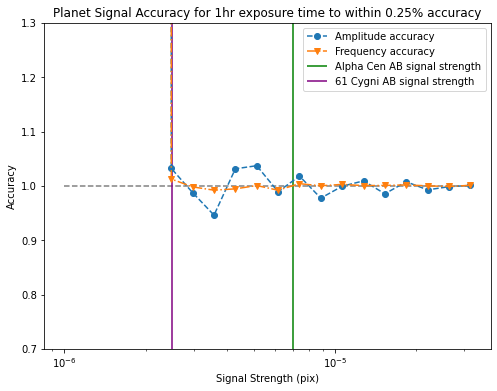

In [46]:
log_sig_range = onp.linspace(4.5, 6, 20)
sig_range = 10**(-log_sig_range)

amp_res = []
freq_res = []

for i in tqdm(range(len(sig_range))):
    ratio = 8.5
    acc1 = recovered_signal_accuracy(sig_range[i], ratio*rao_1hr)
    acc2 = recovered_signal_accuracy(sig_range[i], ratio*rao_1hr)
    acc3 = recovered_signal_accuracy(sig_range[i], ratio*rao_1hr)
    acc4 = recovered_signal_accuracy(sig_range[i], ratio*rao_1hr)
    acc5 = recovered_signal_accuracy(sig_range[i], ratio*rao_1hr)
    acc6 = recovered_signal_accuracy(sig_range[i], ratio*rao_1hr)
    acc7 = recovered_signal_accuracy(sig_range[i], ratio*rao_1hr)
    acc8 = recovered_signal_accuracy(sig_range[i], ratio*rao_1hr)
    acc9 = recovered_signal_accuracy(sig_range[i], ratio*rao_1hr)
    acc10 = recovered_signal_accuracy(sig_range[i], ratio*rao_1hr)
    
    
    mean_acc = (acc1+acc2+acc3+acc4+acc5+acc6+acc7+acc8+acc9+acc10)/10
    
    amp_res = onp.append(amp_res, mean_acc[0])
    freq_res = onp.append(freq_res, mean_acc[1])
    

amp_res[amp_res > 1.3] = 500
amp_res[amp_res < 0.7] = 500

freq_res[freq_res > 1.3] = 500
freq_res[freq_res < 0.7] = 500
    
plt.figure(figsize = (8,6))
plt.plot(sig_range, amp_res, '--o', label ='Amplitude accuracy')
plt.plot(sig_range, freq_res, '-.v', label = 'Frequency accuracy')
plt.xlabel('Signal Strength (pix)')
plt.ylabel('Accuracy')  # change
plt.title('Planet Signal Accuracy for 1hr exposure time to within 0.25% accuracy')

plt.xscale('log')
plt.hlines(1, onp.min(sig_range), onp.max(sig_range), ls = '--', color = 'grey')
plt.vlines(0.7e-5,0.7,1.3, color = 'green', label = 'Alpha Cen AB signal strength')
plt.vlines(0.25e-5,0.7,1.3, color = 'purple', label = '61 Cygni AB signal strength')
plt.ylim([0.7,1.3])
plt.legend()


In [31]:
acc = recovered_signal_accuracy(1e-6, 1.25*5e-6)
print(acc)

[1.05065974 1.00462153]


In [20]:
for i in range(20):
    zern = morphine.zernike.zern_name(i+1)
    print(zern)

Piston
Tilt X
Tilt Y
Focus
Astigmatism 45
Astigmatism 0
Coma Y
Coma X
Trefoil Y
Trefoil X
Spherical
2nd Astig 0
2nd Astig 45
Tetrafoil 0
Tetrafoil 22.5
2nd coma X
2nd coma Y
3rd Astig X
3rd Astig Y
Pentafoil X


In [ ]:
### Checking things

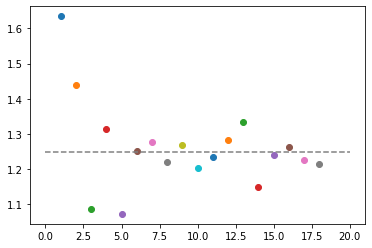

In [21]:
pscale = 0.156
zern_mode = onp.linspace(1,20,20)

for i in range(18):
    zern = morphine.zernike.zern_name(i+1)
    path = '20wavsPSFs/Zernikes/{}/Estimate_Results/1nm-overshot2-5.npy'.format(zern)
    std = jnp.std(onp.load(path))
    std = std*(2/pscale)
    std = std/(5.88e-6)
    
    plt.scatter(zern_mode[i], std)
    
plt.hlines(1.25,0,20, ls = '--', color = 'grey')

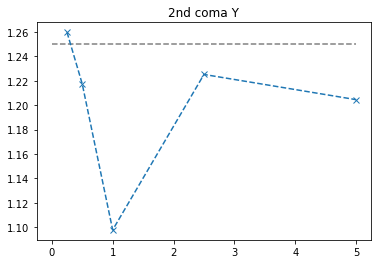

In [47]:
zern = morphine.zernike.zern_name(17)

std1 = onp.std(onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/1nm-overshot0-25.npy'.format(zern)))
std2 = onp.std(onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/1nm-overshot0-5.npy'.format(zern)))
std3 = onp.std(onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/1nm-overshot1.npy'.format(zern)))
std4 = onp.std(onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/1nm-overshot2-5.npy'.format(zern)))
std5 = onp.std(onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/1nm-overshot5.npy'.format(zern)))

x_range = [0.25, 0.5, 1, 2.5, 5]
stds = onp.array([std1, std2, std3, std4, std5])
stds = stds*(2/pscale)
stds = stds/(5.88e-6)

plt.figure()
plt.plot(x_range, stds, '--x')
plt.title(zern)
plt.hlines(1.25,0,5, ls = '--', color = 'grey')